## Question 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv("../HW4_train.csv")
train_df = train_df.sample(n=10000, random_state=1)
future_df = pd.read_csv("../HW4_future.csv")

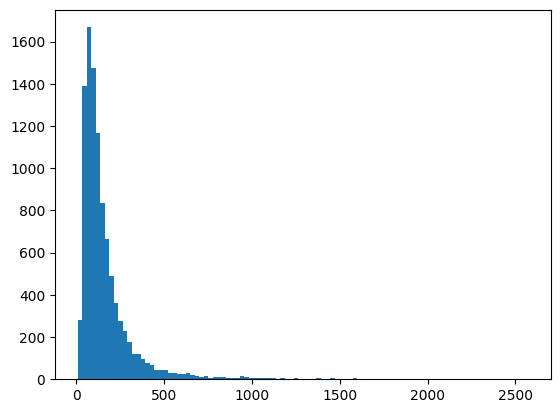

In [24]:
plt.hist(train_df['price'], bins=100)
plt.show()

In [3]:
X = train_df.drop(columns=['price'])
y = train_df['price']

In [4]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols.remove("id")

In [6]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [7]:
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.3, random_state=1)

In [8]:
def conformal_prediction_analysis(model, name):
    # fit pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)

    y_calib_pred = pipeline.predict(X_calib)
    residuals = np.abs(y_calib - y_calib_pred)

    alpha = 0.05
    q_hat = np.quantile(residuals, 1 - alpha)

    lb = y_calib_pred - q_hat
    ub = y_calib_pred + q_hat

    coverage = np.mean((y_calib >= lb) & (y_calib <= ub))
    avg_length = np.mean(ub - lb)

    print(f"Model: {name}")
    print(f"  Coverage: {coverage:.3f}")
    print(f"  Avg. Interval Length: {avg_length:.2f}")
    print()

    future_preds = pipeline.predict(future_df)
    future_lb = future_preds - q_hat
    future_ub = future_preds + q_hat

    return future_lb, future_ub


In [15]:
# Model 1: Random Forest
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=0)
rf_lb, rf_ub = conformal_prediction_analysis(rf_model, "Random Forest")

# Model 2: Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, max_depth=4, random_state=0)
gb_lb, gb_ub = conformal_prediction_analysis(gb_model, "Gradient Boosting")

Model: Random Forest
  Coverage: 0.950
  Avg. Interval Length: 435.91

Model: Gradient Boosting
  Coverage: 0.950
  Avg. Interval Length: 407.47



In [16]:
output = pd.DataFrame({
    "id": future_df["id"],
    "lower_bound": gb_lb,
    "upper_bound": gb_ub
})

output.to_csv("HW4_Q2b.csv", index=False)

## Question 3

In [26]:
train_df['instant_bookable'].value_counts()

instant_bookable
f    7369
t    2631
Name: count, dtype: int64

In [27]:
import statsmodels.api as sum

In [36]:
import pandas as pd
import statsmodels.api as sm

# Load and clean data
df = pd.read_csv("../HW4_train.csv")
keep_cols = ["price", "instant_bookable", "city", "accommodates", "room_type"]
df = df[keep_cols].dropna()

# Convert treatment to binary
df["instant_bookable"] = (df["instant_bookable"] == "t").astype(int)
# Create dummy vars for categorical confounders
df = pd.get_dummies(df, columns=["city", "room_type"], drop_first=True, dtype="int")

# Set up regression
X = df.drop(columns=["price"])
X = sm.add_constant(X)  # add intercept
y = df["price"]

model = sm.OLS(y, X).fit()

# Show results
print(model.summary())

coef = model.params["instant_bookable"]
pval = model.pvalues["instant_bookable"]

print(f"\nCoefficient for instant_bookable: {coef:.2f}")
print(f"P-value: {pval:.4f}")

alpha = 0.05
if pval < alpha:
    print("Reject null: Being instantly bookable has a statistically significant effect on price.")
else:
    print("Fail to reject null: No statistically significant effect of instant bookable on price.")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     2284.
Date:                Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:26:09   Log-Likelihood:            -3.1390e+05
No. Observations:               48912   AIC:                         6.278e+05
Df Residuals:                   48902   BIC:                         6.279e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     81

## Question 4

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [39]:
df = pd.read_csv("../HW4_train.csv")
df = df[["price", "instant_bookable", "bathrooms", "accommodates", "cancellation_policy"]]
df = df.dropna()

In [40]:
df["instant_bookable"] = (df["instant_bookable"] == "t").astype(int)

df = pd.get_dummies(df, columns=["cancellation_policy"], drop_first=True)

In [41]:
X = df.drop(columns=["price", "instant_bookable"])
T = df["instant_bookable"]
y = df["price"]

In [42]:
X_treat = X[T == 1]
y_treat = y[T == 1]
X_control = X[T == 0]
y_control = y[T == 0]

In [43]:
def make_model(input_dim):
    model = Sequential()
    model.add(Dense(4, activation='relu', input_dim=input_dim))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

In [44]:
model_treat = make_model(X.shape[1])
model_treat.fit(X_treat, y_treat, epochs=30, verbose=0)

model_control = make_model(X.shape[1])
model_control.fit(X_control, y_control, epochs=30, verbose=0)

c:\Users\Simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
mu1 = model_treat.predict(X, verbose=0).flatten()
mu0 = model_control.predict(X, verbose=0).flatten()
cate = mu1 - mu0

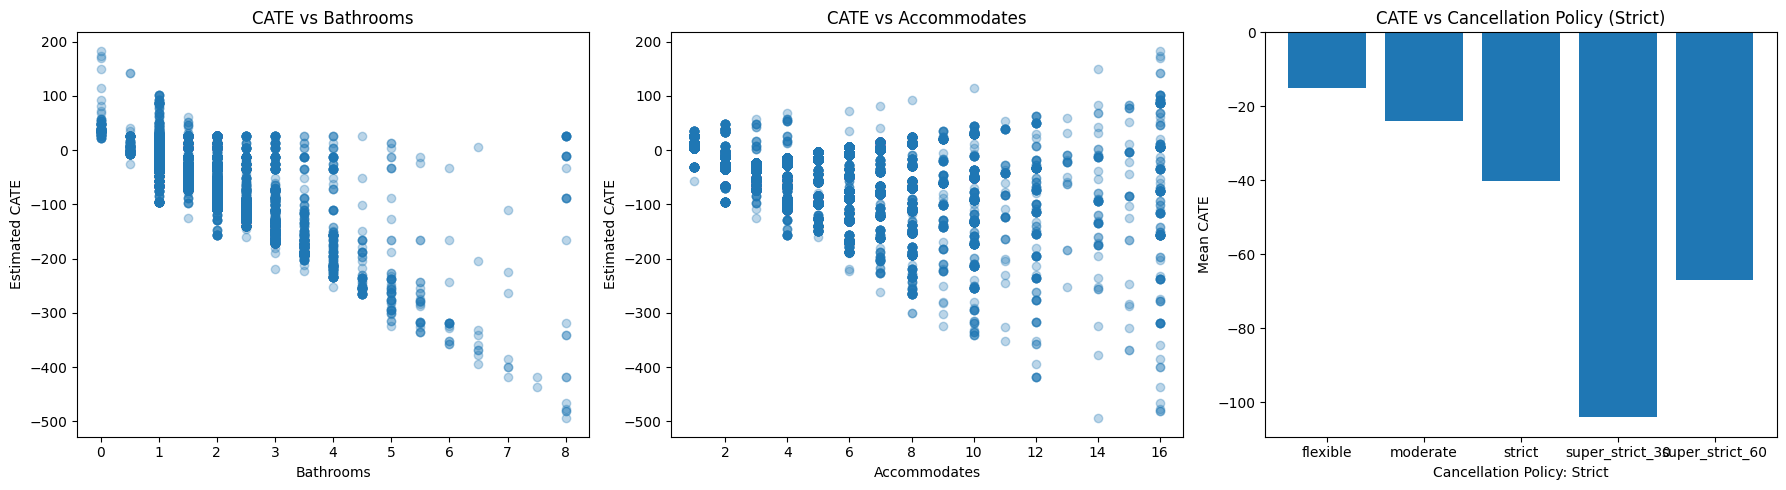

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(df["bathrooms"], cate, alpha=0.3)
axs[0].set_xlabel("Bathrooms")
axs[0].set_ylabel("Estimated CATE")
axs[0].set_title("CATE vs Bathrooms")

axs[1].scatter(df["accommodates"], cate, alpha=0.3)
axs[1].set_xlabel("Accommodates")
axs[1].set_ylabel("Estimated CATE")
axs[1].set_title("CATE vs Accommodates")

# plot CATE by category
df["cate"] = cate
df["cancellation_policy"] = pd.read_csv("../HW4_train.csv")["cancellation_policy"]
cate_means = df.groupby("cancellation_policy")["cate"].mean()

axs[2].bar(cate_means.index, cate_means.values)
axs[2].set_xlabel("Cancellation Policy: Strict")
axs[2].set_ylabel("Mean CATE")
axs[2].set_title("CATE vs Cancellation Policy (Strict)")

plt.tight_layout()
plt.show()

In [47]:
train_df['cancellation_policy'].value_counts()

cancellation_policy
strict             4278
flexible           3038
moderate           2592
super_strict_60      75
super_strict_30      17
Name: count, dtype: int64